In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aspillai/tesla-stock-price-with-indicators-10-years")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\naman\.cache\kagglehub\datasets\aspillai\tesla-stock-price-with-indicators-10-years\versions\1


In [35]:
# Import all the required libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [36]:
df = pd.read_csv(r"C:\Users\naman\Downloads\tsla_2014_2023.csv")


In [37]:
# Drop rows with missing values (if any)
df = df.dropna()

In [38]:
# Create target variable: 1 if price increases > 2% in 5 days, 0 otherwise
df['Future_close'] = df['close'].shift(-5)
df['Price_Change'] = (df['Future_close'] - df['close']) / df['close'] * 100
df['Target'] = (df['Price_Change'] > 2).astype(int)

In [39]:
# Drop rows where Future_close is NaN (last 5 rows)
df = df.dropna(subset=['Future_close'])
print("Rows after dropping NaN in Future_close:", df.shape[0])

Rows after dropping NaN in Future_close: 2511


In [40]:
# Feature engineering: Add daily returns and lagged returns
df['Daily_Return'] = df['close'].pct_change() * 100
df['Lag1_Return'] = df['Daily_Return'].shift(1)
df['Lag5_Return'] = df['Daily_Return'].shift(5)

In [41]:
# Outlier detection and removal
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

outlier_columns = ['open', 'high', 'low', 'close', 'volume']
df = remove_outliers(df, outlier_columns)
print("Rows after outlier removal:", df.shape[0])

Rows after outlier removal: 2335


In [42]:
# Handle class imbalance with SMOTE after imputing NaN values
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

In [43]:
# Define features and target
features = ['open', 'high', 'low', 'close', 'volume', 'sma_50', 'rsi_14', 'macd', 
            'Lag1_Return', 'Lag5_Return']
X = df[features]
y = df['Target']

In [44]:
# Check for NaN values (already done, but keeping for reference)
print("NaN counts in each feature column:")
print(X.isna().sum())

NaN counts in each feature column:
open           0
high           0
low            0
close          0
volume         0
sma_50         0
rsi_14         0
macd           0
Lag1_Return    2
Lag5_Return    6
dtype: int64


In [45]:
# Impute NaN values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [46]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_imputed, y)

In [47]:
# Convert back to DataFrame
df_balanced = pd.DataFrame(X_balanced, columns=features)
df_balanced['Target'] = y_balanced

In [48]:
# Check class distribution
print("Original class distribution:\n", y.value_counts())
print("Balanced class distribution:\n", y_balanced.value_counts())

Original class distribution:
 Target
0    1383
1     952
Name: count, dtype: int64
Balanced class distribution:
 Target
0    1383
1    1383
Name: count, dtype: int64


In [49]:
# Split into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X = df_balanced[features]
y = df_balanced['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [50]:
# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Preview the final DataFrame shape
print("Final balanced DataFrame shape:", df_balanced.shape)

Final balanced DataFrame shape: (2766, 11)


In [52]:
#Calculate correlation matrix for all features plus Target
correlation_matrix = df_balanced[features + ['Target']].corr()

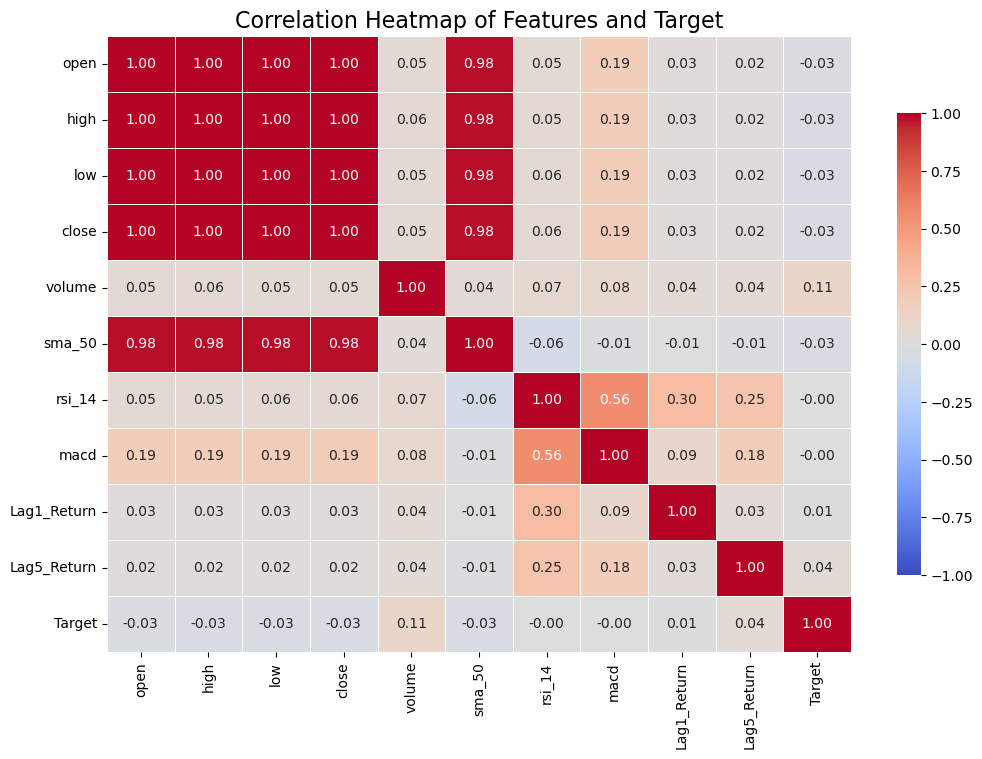

In [53]:
# Create a heatmap to visualize correlations
plt.figure(figsize=(12, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
           fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.75})
plt.title('Correlation Heatmap of Features and Target', fontsize=16)
plt.show()

In [4]:
#Now we will implement models via logistic regression, xgboost and random forest and compare the three

In [3]:
# Import necessary libraries for modeling and evaluation
from sklearn.linear_model import LogisticRegression  # Note: Using LogisticRegression for binary classification
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

In [61]:
# Function to calculate regression-like metrics (MSE, RSS, TSS) using predicted probabilities
def calculate_regression_metrics(y_true, y_prob):
    """
    Calculate MSE, RSS, and TSS using predicted probabilities for a classification task.
    Note: This is unconventional for classification but included for educational purposes.
    """
    # Mean Squared Error (MSE) using predicted probabilities
    mse = np.mean((y_true - y_prob) ** 2)
    
    # Residual Sum of Squares (RSS) using predicted probabilities
    rss = np.sum((y_true - y_prob) ** 2)
    
    # Total Sum of Squares (TSS) using the mean of actual labels
    y_mean = np.mean(y_true)
    tss = np.sum((y_true - y_mean) ** 2)
    
    return mse, rss, tss

In [62]:
# Function to extract Precision and Sensitivity (Recall) from classification report
def extract_precision_recall(classification_report_dict, class_label=1):
    """
    Extract Precision and Sensitivity (Recall) for the specified class (default is positive class: 1).
    """
    precision = classification_report_dict[str(class_label)]['precision']
    recall = classification_report_dict[str(class_label)]['recall']  # Sensitivity is the same as Recall
    return precision, recall

In [1]:
# Function to train a model, make predictions, and print evaluation metrics
def evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions (hard predictions: 0 or 1)
    y_pred = model.predict(X_test_scaled)
    
    # Get predicted probabilities (for positive class) for regression-like metrics
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Get classification report as a dictionary to extract Precision and Sensitivity
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    # Extract Precision and Sensitivity (Recall) for positive class (1)
    precision, sensitivity = extract_precision_recall(report_dict, class_label=1)
    
    # Calculate regression-like metrics (MSE, RSS, TSS) using predicted probabilities
    mse, rss, tss = calculate_regression_metrics(y_test, y_prob)
    
    # Print evaluation metrics
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Positive Class): {precision:.4f}")
    print(f"Sensitivity/Recall (Positive Class): {sensitivity:.4f}")
    print(f"Mean Squared Error (using probabilities): {mse:.4f}")
    print(f"Residual Sum of Squares (RSS, using probabilities): {rss:.4f}")
    print(f"Total Sum of Squares (TSS, using probabilities): {tss:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    return accuracy, precision, sensitivity, mse, rss, tss, y_pred

In [64]:
# 1. Logistic Regression (Using Logistic Regression for binary classification)
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_metrics = evaluate_model(logistic_model, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")
logistic_accuracy, logistic_precision, logistic_sensitivity, logistic_mse, logistic_rss, logistic_tss, logistic_pred = logistic_metrics


--- Logistic Regression ---
Accuracy: 0.2292
Precision (Positive Class): 1.0000
Sensitivity/Recall (Positive Class): 0.1067
Mean Squared Error (using probabilities): 0.3177
Residual Sum of Squares (RSS, using probabilities): 175.9991
Total Sum of Squares (TSS, using probabilities): 65.5740

Classification Report:
              precision    recall  f1-score   support

           0       0.15      1.00      0.26        76
           1       1.00      0.11      0.19       478

    accuracy                           0.23       554
   macro avg       0.58      0.55      0.23       554
weighted avg       0.88      0.23      0.20       554


Confusion Matrix:
[[ 76   0]
 [427  51]]


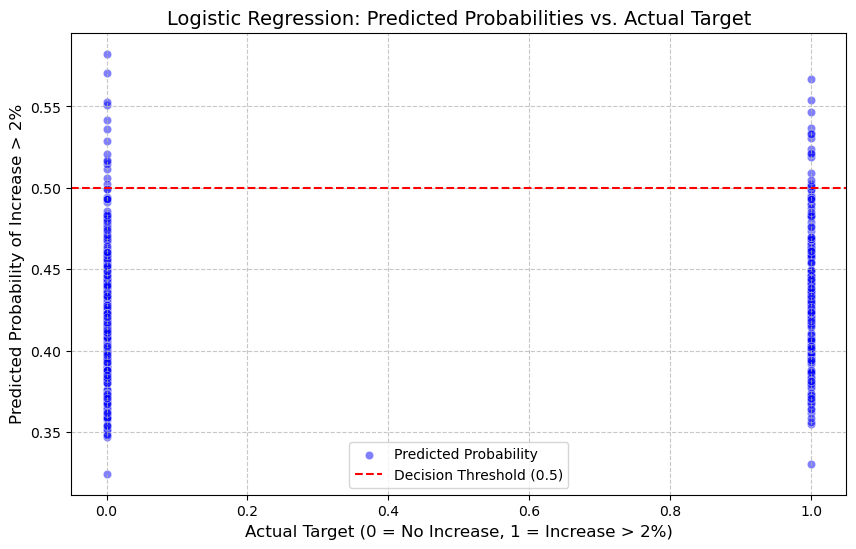

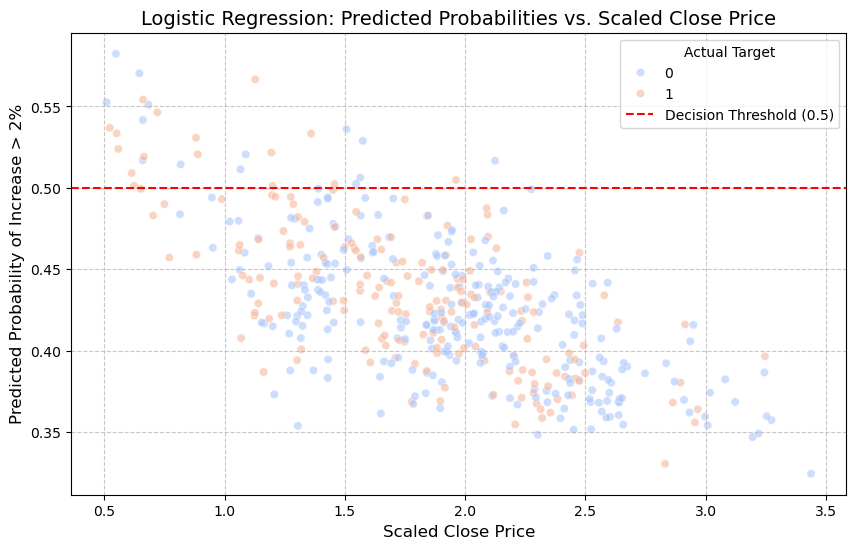

In [5]:
# Plotting scatter plots for logistic regression
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset (adjust path as needed)
df = pd.read_csv(r"C:\Users\naman\Downloads\tsla_2014_2023.csv")

# Drop rows with missing values (if any)
df = df.dropna()

# Function to remove outliers
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Apply outlier removal
outlier_columns = ['open', 'high', 'low', 'close', 'volume']
df = remove_outliers(df, outlier_columns)

# Feature engineering
df['Future_close'] = df['close'].shift(-5)
df['Price_Change'] = (df['Future_close'] - df['close']) / df['close'] * 100
df['Target'] = (df['Price_Change'] > 2).astype(int)
df = df.dropna(subset=['Future_close'])
df['Daily_Return'] = df['close'].pct_change() * 100
df['Lag1_Return'] = df['Daily_Return'].shift(1)
df['Lag5_Return'] = df['Daily_Return'].shift(5)

# Define features and target
features = ['open', 'high', 'low', 'close', 'volume', 'sma_50', 'rsi_14', 'macd', 'Lag1_Return', 'Lag5_Return']
X = df[features]
y = df['Target']

# Impute NaN values with mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Get predicted probabilities and binary predictions
y_pred_prob = logistic_model.predict_proba(X_test_scaled)[:, 1]
y_pred = logistic_model.predict(X_test_scaled)

# First scatter plot: Predicted probabilities vs. Actual target
plt.figure(figsize=(10, 6))
sb.scatterplot(x=y_test, y=y_pred_prob, alpha=0.5, color='blue', label='Predicted Probability')
plt.axhline(y=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
plt.xlabel('Actual Target (0 = No Increase, 1 = Increase > 2%)', fontsize=12)
plt.ylabel('Predicted Probability of Increase > 2%', fontsize=12)
plt.title('Logistic Regression: Predicted Probabilities vs. Actual Target', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Second scatter plot: Predicted probabilities vs. Scaled Close Price
# Reset index of y_test to match X_test_df
X_test_df = pd.DataFrame(X_test_scaled, columns=features, index=y_test.index)  # Align indices
plt.figure(figsize=(10, 6))
sb.scatterplot(x=X_test_df['close'], y=y_pred_prob, hue=y_test, palette='coolwarm', alpha=0.6)
plt.axhline(y=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
plt.xlabel('Scaled Close Price', fontsize=12)
plt.ylabel('Predicted Probability of Increase > 2%', fontsize=12)
plt.title('Logistic Regression: Predicted Probabilities vs. Scaled Close Price', fontsize=14)
plt.legend(title='Actual Target')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [65]:
# 2. XGBoost
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgboost_metrics = evaluate_model(xgboost_model, X_train_scaled, X_test_scaled, y_train, y_test, "XGBoost")
xgboost_accuracy, xgboost_precision, xgboost_sensitivity, xgboost_mse, xgboost_rss, xgboost_tss, xgboost_pred = xgboost_metrics


--- XGBoost ---
Accuracy: 0.5686
Precision (Positive Class): 0.9223
Sensitivity/Recall (Positive Class): 0.5460
Mean Squared Error (using probabilities): 0.2829
Residual Sum of Squares (RSS, using probabilities): 156.7341
Total Sum of Squares (TSS, using probabilities): 65.5740

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.71      0.31        76
           1       0.92      0.55      0.69       478

    accuracy                           0.57       554
   macro avg       0.56      0.63      0.50       554
weighted avg       0.82      0.57      0.63       554


Confusion Matrix:
[[ 54  22]
 [217 261]]


C:\Users\naman\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [66]:
# 3. Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_metrics = evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")
rf_accuracy, rf_precision, rf_sensitivity, rf_mse, rf_rss, rf_tss, rf_pred = rf_metrics


--- Random Forest ---
Accuracy: 0.5704
Precision (Positive Class): 0.9286
Sensitivity/Recall (Positive Class): 0.5439
Mean Squared Error (using probabilities): 0.2497
Residual Sum of Squares (RSS, using probabilities): 138.3349
Total Sum of Squares (TSS, using probabilities): 65.5740

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.74      0.32        76
           1       0.93      0.54      0.69       478

    accuracy                           0.57       554
   macro avg       0.57      0.64      0.50       554
weighted avg       0.83      0.57      0.64       554


Confusion Matrix:
[[ 56  20]
 [218 260]]


In [69]:
#now let us implement another type of machine learning

In [70]:
pip install tensorflow

   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
    --------------------------------------- 7.3/376.0 MB 37.6 MB/s eta 0:00:10
   - -------------------------------------- 10.5/376.0 MB 26.1 MB/s eta 0:00:14
   - -------------------------------------- 12.6/376.0 MB 20.2 MB/s eta 0:00:18
   - -------------------------------------- 14.4/376.0 MB 17.8 MB/s eta 0:00:21
   - -------------------------------------- 16.5/376.0 MB 15.8 MB/s eta 0:00:23
   - -------------------------------------- 18.6/376.0 MB 14.9 MB/s eta 0:00:25
   -- ------------------------------------- 20.2/376.0 MB 13.7 MB/s eta 0:00:26
   -- ------------------------------------- 22.5/376.0 MB 13.5 MB/s eta 0:00:27
   -- ------------------------------------- 24.6/376.0 MB 13.0 MB/s eta 0:00:28
   -- ------------------------------------- 26.5/376.0 MB 12.7 MB/s eta 0:00:28
   --- ------------------------------------ 28.3/376.0 MB 12.4 MB/s eta 0:00:29
   --- ------------------------------------ 30.4/3

In [71]:
# Import TensorFlow/Keras for LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [72]:
# Function to reshape data into 3D format for LSTM
def create_lstm_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i + timesteps])
        y_seq.append(y[i + timesteps])
    return np.array(X_seq), np.array(y_seq)

In [108]:
# Define the number of timesteps (look back 5 days)
timesteps = 500

In [109]:
# Reshape training and testing data for LSTM
X_train_lstm, y_train_lstm = create_lstm_sequences(X_train_scaled, y_train.values, timesteps)
X_test_lstm, y_test_lstm = create_lstm_sequences(X_test_scaled, y_test.values, timesteps)

print("LSTM Training Data Shape:", X_train_lstm.shape)
print("LSTM Testing Data Shape:", X_test_lstm.shape)

LSTM Training Data Shape: (1712, 500, 10)
LSTM Testing Data Shape: (54, 500, 10)


In [110]:
# Function to build, train, and evaluate the LSTM model
def evaluate_lstm(X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, timesteps, n_features, model_name="LSTM"):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, 
                        validation_data=(X_test_lstm, y_test_lstm), verbose=1)

    y_pred_prob = model.predict(X_test_lstm)
    y_pred = (y_pred_prob > 0.5).astype(int)

    accuracy = accuracy_score(y_test_lstm, y_pred)

    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_lstm, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_lstm, y_pred))

    return model, accuracy, y_pred

In [111]:
# Get the number of features
n_features = X_train_scaled.shape[1]

In [112]:
# Train and evaluate the LSTM model
lstm_model, lstm_accuracy, lstm_pred = evaluate_lstm(X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, 
                                                     timesteps, n_features)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - accuracy: 0.5737 - loss: 0.6833 - val_accuracy: 0.5000 - val_loss: 0.6994
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.5699 - loss: 0.6716 - val_accuracy: 0.2407 - val_loss: 0.7419
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - accuracy: 0.6168 - loss: 0.6581 - val_accuracy: 0.7778 - val_loss: 0.6313
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.6331 - loss: 0.6455 - val_accuracy: 0.9259 - val_loss: 0.5530
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.6382 - loss: 0.6390 - val_accuracy: 0.8519 - val_loss: 0.5916
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.6511 - loss: 0.6257 - val_accuracy: 0.8519 - val_loss: 0.5600
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.6622 - loss: 0.6154 - val_accuracy: 1.0000 - val_loss: 0.4258
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.6547 - loss: 0.6161 - val_accu

C:\Users\naman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [89]:
# --- Model Comparison with LSTM ---

print("\n--- Model Comparison ---")
print(f"{'Model':<20} {'Accuracy':<10}")
print("-" * 30)
print(f"{'Logistic Regression':<20} {logistic_accuracy:<10.4f}")
print(f"{'XGBoost':<20} {xgboost_accuracy:<10.4f}")
print(f"{'Random Forest':<20} {rf_accuracy:<10.4f}")
print(f"{'LSTM':<20} {lstm_accuracy:<10.4f}")


--- Model Comparison ---
Model                Accuracy  
------------------------------
Logistic Regression  0.2292    
XGBoost              0.5686    
Random Forest        0.5704    
LSTM                 0.7407    


In [90]:
# Update accuracies dictionary
accuracies = {
    "Logistic Regression": logistic_accuracy,
    "XGBoost": xgboost_accuracy,
    "Random Forest": rf_accuracy,
    "LSTM": lstm_accuracy
}

In [91]:
# Determine the best model based on accuracy
best_model_name = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model_name]
print(f"\nBest Model (Based on Accuracy): {best_model_name} with Accuracy: {best_accuracy:.4f}")


Best Model (Based on Accuracy): LSTM with Accuracy: 0.7407


In [92]:
# Assign the best model object
if best_model_name == "Logistic Regression":
    best_model = logistic_model
elif best_model_name == "XGBoost":
    best_model = xgboost_model
elif best_model_name == "Random Forest":
    best_model = rf_model
elif best_model_name == "LSTM":
    best_model = lstm_model

In [93]:
# Updated prediction function to handle LSTM and other models
def predict_stock_increase(model, X_new, model_name, scaler, timesteps=None, context=""):
    if model_name == "LSTM":
        X_new_scaled = scaler.transform(X_new)
        X_new_lstm = np.array([X_new_scaled[-timesteps:]])
        pred_prob = model.predict(X_new_lstm)[0][0]
        pred = 1 if pred_prob > 0.5 else 0
    else:
        X_new_scaled = scaler.transform(X_new)
        pred = model.predict(X_new_scaled)[0]
        pred_prob = model.predict_proba(X_new_scaled)[0, 1]

    pred_label = "Increase > 2%" if pred == 1 else "No Increase > 2%"
    confidence = pred_prob if pred == 1 else 1 - pred_prob

    print(f"\n--- Prediction for Tesla Stock {context} ---")
    print(f"Model Used: {model_name}")
    print(f"Prediction: {pred_label}")
    print(f"Probability of Increase > 2%: {pred_prob:.4f}")
    print(f"Confidence in Prediction: {confidence:.4f}")
    return pred, pred_prob

In [94]:
# Generate random but plausible feature values within the range of the dataset
feature_ranges = df[features].describe().loc[['min', 'max']]
np.random.seed(42)
random_values = {feature: np.random.uniform(feature_ranges[feature]['min'], feature_ranges[feature]['max']) 
                 for feature in features}
random_df = pd.DataFrame([random_values], columns=features)

print("\n--- Random Feature Values for Simulation (Given Day) ---")
print(random_df.to_string(index=False))


--- Random Feature Values for Simulation (Given Day) ---
      open       high        low      close       volume    sma_50    rsi_14      macd  Lag1_Return  Lag5_Return
160.046386 394.550918 299.407974 249.160214 4.506623e+07 63.836275 21.073381 29.591625     6.376319     8.893302


In [100]:
# Make prediction with random values
pred_random, prob_random = predict_stock_increase(best_model, random_df[features], best_model_name, 
                                                  scaler, timesteps if best_model_name == "LSTM" else None, 
                                                  context="(Simulated Given Day)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step

--- Prediction for Tesla Stock (Simulated Given Day) ---
Model Used: LSTM
Prediction: No Increase > 2%
Probability of Increase > 2%: 0.3970
Confidence in Prediction: 0.6030


In [96]:
# Summarize the Results
print("\n--- Summary of Simulation Results ---")
print(f"Prediction for Simulated Given Day:")
print(f"   Prediction: {'Increase > 2%' if pred_random == 1 else 'No Increase > 2%'}")
print(f"   Probability of Increase > 2%: {prob_random:.4f}")
print("\nNote: This prediction is a simulation based on randomly generated feature values within the historical data range.")


--- Summary of Simulation Results ---
Prediction for Simulated Given Day:
   Prediction: No Increase > 2%
   Probability of Increase > 2%: 0.3970

Note: This prediction is a simulation based on randomly generated feature values within the historical data range.


In [98]:
#Save the scaler and best model
joblib.dump(scaler, "scaler.pkl")
if best_model_name == "LSTM":
    best_model.save("best_model_lstm.h5")
else:
    joblib.dump(best_model, "best_model.pkl")

In [99]:
# Load them later if needed
scaler = joblib.load("scaler.pkl")
if best_model_name == "LSTM":
    from tensorflow.keras.models import load_model
    best_model = load_model("best_model_lstm.h5")
else:
    best_model = joblib.load("best_model.pkl")